In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.random import randn
from scipy.misc import bytescale
!pip3 install -q progressbar2 
from progressbar import ProgressBar
from time import time
import csv
from scipy.stats import pearsonr

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/CompNeuro')

## Grid Search

In [ ]:
conds = {}
conds['HE_Go'] = 0.94
conds['HE_Change'] = .72
conds['LE_Go'] = 0.98
conds['LE_Change'] = 0.90
cond_names = list(conds.keys())

labels = [1., -1., 1., -1.]

upper_bound, lower_bound = 1., -1.  # upper and lower bounds 
noise = .05  # noise parameter
drift_vals = np.linspace(-.01, .01, num=25)  # grid of drift rate values to test
bias_vals = np.linspace(-.7, .7, num=25)   # list of bias values to test
dt = .001
n_reps = 25
surface = np.zeros([drift_vals.size, bias_vals.size, len(cond_names), n_reps])  # surface on which performance will be plotted --- bias x drift x condition
n_trials = 10  # number of trials
bar = ProgressBar()

In [ ]:
for rep in bar(range(n_reps)):
  for cond_num, cond in enumerate(cond_names):  # loop through each condition
    label = labels[cond_num]  # get that condition's correct action

    for drift_num, drift_val in enumerate(drift_vals):  # loop through drift values 
      for bias_num, bias_val in enumerate(bias_vals):  # loop through bias values
        prob = 0.  # each set of values, initialize probability of correct at 0.

        for trial in range(n_trials):  # perform n_trials trials
          z = bias_val  # start at respective bias value being tested
          continue_trial = True

          while continue_trial:
            z += drift_val * dt + randn() * noise  # update the position

            # if it reaches the upper decision boundary stop trial
            if z >= upper_bound:
              continue_trial = False
              if label == 1:  # if upper boundary was desired decision, add 1 to prob(correct)
                prob += 1.

            # if it reaches the lower decision boundary stop trial
            elif z <= lower_bound:
              continue_trial = False
              if label == -1:  # if lower boundary was desired decision, add 1 to prob(correct)
                prob += 1.


        prob = prob / float(n_trials)  # calculate the probability of correct actions
        surface[drift_num, bias_num, cond_num, rep] = (prob - conds[cond])**2 # put that probability difference in the surface at the appropriate spot      

100% (25 of 25) |########################| Elapsed Time: 0:03:44 Time:  0:03:44


In [ ]:
surface = np.mean(surface, 3)

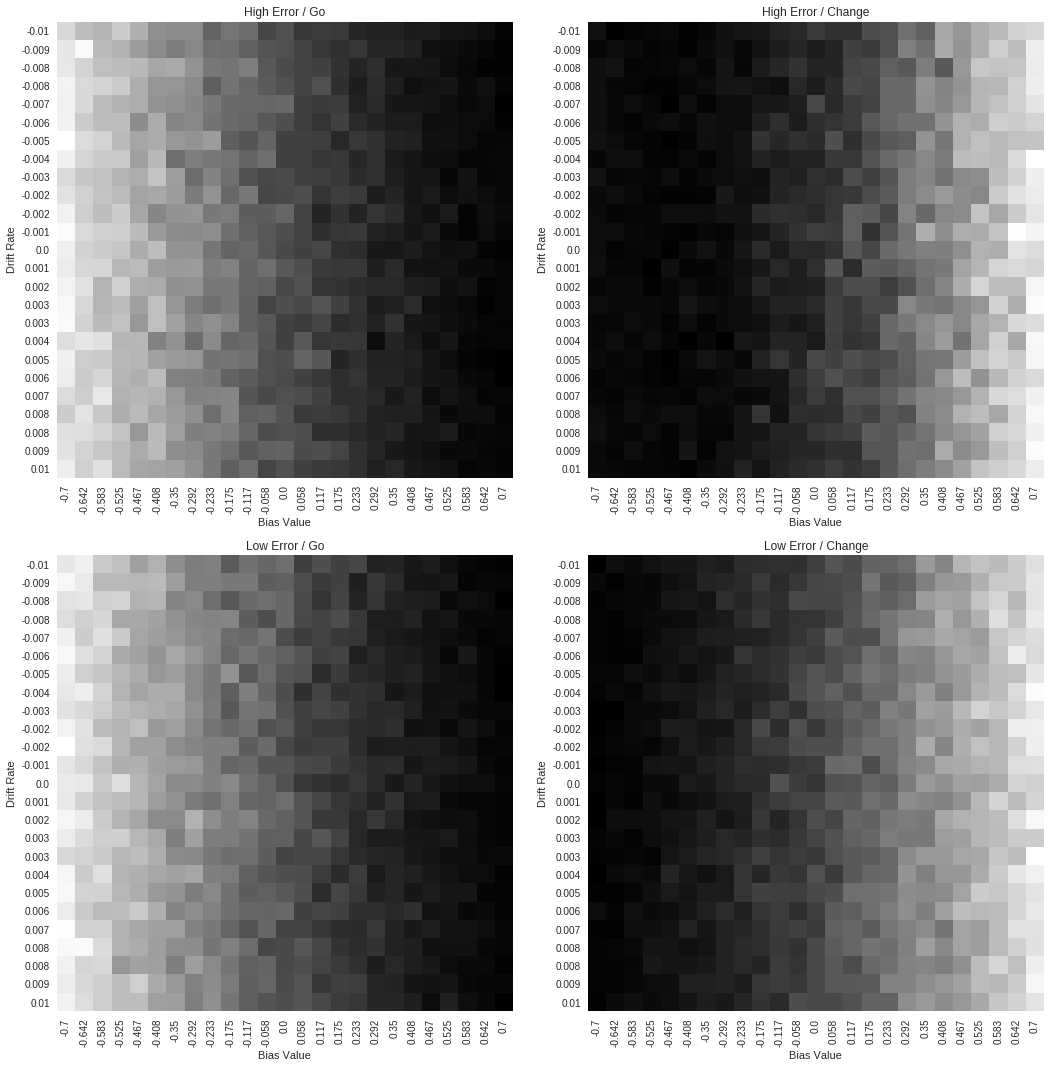

In [ ]:
fig = plt.figure(figsize=(15, 15))
he_go = fig.add_subplot(221)
he_change = fig.add_subplot(222)
le_go = fig.add_subplot(223)
le_change = fig.add_subplot(224)
bias_labels = [str(np.round(b, 3)) for b in bias_vals]
drift_labels = [str(np.round(d, 3)) for d in drift_vals]

he_go.set_title('High Error / Go') # give a title to the subplot
he_go.set_ylabel('Drift Rate')  # name the y-axis
he_go.set_xlabel('Bias Value')  # name the x-axis
he_go.imshow(surface[..., 0], cmap='gray')
he_go.set_yticks(np.arange(len(drift_labels)))
he_go.set_yticklabels(drift_labels)
he_go.set_xticks(np.arange(len(bias_labels)))
he_go.set_xticklabels(bias_labels, rotation='vertical')
he_go.grid(False)


he_change.set_title('High Error / Change')
he_change.set_ylabel('Drift Rate')  # name the y-axis
he_change.set_xlabel('Bias Value')  # name the x-axis
he_change.imshow(surface[..., 1], cmap='gray')
he_change.set_yticks(np.arange(len(drift_labels)))
he_change.set_yticklabels(drift_labels)
he_change.set_xticks(np.arange(len(bias_labels)))
he_change.set_xticklabels(bias_labels, rotation='vertical')
he_change.grid(False)


le_go.set_title('Low Error / Go')
le_go.set_ylabel('Drift Rate')  # name the y-axis
le_go.set_xlabel('Bias Value')  # name the x-axis
le_go.imshow(surface[..., 2], cmap='gray')
le_go.set_yticks(np.arange(len(drift_labels)))
le_go.set_yticklabels(drift_labels)
le_go.set_xticks(np.arange(len(bias_labels)))
le_go.set_xticklabels(bias_labels, rotation='vertical')
le_go.grid(False)


le_change.set_title('Low Error / Change')
le_change.set_ylabel('Drift Rate')  # name the y-axis
le_change.set_xlabel('Bias Value')  # name the x-axis
le_change.imshow(surface[..., 3], cmap='gray')
le_change.set_yticks(np.arange(len(drift_labels)))
le_change.set_yticklabels(drift_labels)
le_change.set_xticks(np.arange(len(bias_labels)))
le_change.set_xticklabels(bias_labels, rotation='vertical')
le_change.grid(False)

plt.tight_layout()

In [ ]:
drift_params = [drift_vals[np.where(surface[..., c] == np.amin(surface[..., c]))[0][0]] for c in range(4)]
bias_params = [bias_vals[np.where(surface[..., c] == np.amin(surface[..., c]))[1][0]] for c in range(4)]

In [ ]:
print(drift_params, bias_params)

[-0.006666666666666666, 0.005000000000000001, -0.004166666666666667, -0.003333333333333333] [0.7, -0.4666666666666667, 0.7, -0.6416666666666666]


## Simulation

In [ ]:
noise = .075  # noise parameter
n_trials = 10  # number of trials (subjects)
reps = 100
rts, probs = np.zeros([4, n_trials, reps]), np.zeros([4, n_trials, reps])

In [ ]:
for rep in range(reps):
  for cond_num, cond in enumerate(cond_names):
    label = labels[cond_num]
    drift_rate, bias = drift_params[cond_num], bias_params[cond_num]

    for trial in range(n_trials):
      continue_trial = True
      z = bias
      start_time = time()

      while continue_trial:
        z += drift_rate * dt + randn() * noise

        # if it reaches the upper decision boundary stop trial
        if z >= upper_bound:
          continue_trial = False
          if label == 1:  # if upper boundary was desired decision, add 1 to prob(correct)
            probs[cond_num, trial, rep] = 1.

        # if it reaches the lower decision boundary stop trial
        elif z <= lower_bound:
          continue_trial = False
          if label == -1:  # if lower boundary was desired decision, add 1 to prob(correct)
            probs[cond_num, trial, rep] = 1.

      rts[cond_num, trial, rep] = time() - start_time

In [ ]:
np.mean(probs, 1).shape

(4, 100)

In [ ]:
print('Mean Accuracies', np.mean(np.mean(probs, 1), 1))
print('STD Accuracies', np.mean(np.std(probs, 1), 1))

Mean Accuracies [0.834 0.707 0.844 0.814]
STD Accuracies [0.33100425 0.41072192 0.29603149 0.34009562]


In [ ]:
print('Mean Reaction Time', np.mean(np.mean(rts, 1), 1))
print('STD Reaction Time', np.mean(np.std(rts, 1), 1))

Mean Reaction Time [0.00011212 0.000167   0.00010598 0.00011383]
STD Reaction Time [0.00012516 0.00016481 0.00011815 0.0001199 ]


## fMRI Data

In [ ]:
datafile = loadmat('fmri_CST_data.mat')

In [ ]:
print(list(datafile.keys()))

['__header__', '__version__', '__globals__', 'img_sequence']


In [ ]:
data = datafile['img_sequence'] + 1e-10

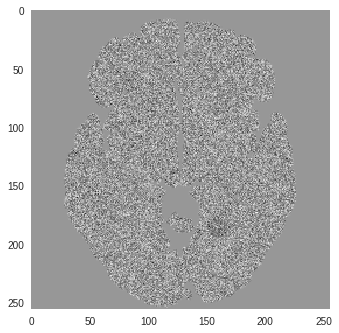

In [ ]:
plt.imshow(data[..., 0])
plt.grid(False)

In [ ]:
drift_rates, biases = np.zeros([100, ]), np.zeros([100, ])

with open('TrialLabels.txt', 'r') as label_file:
  reader = csv.reader(label_file, delimiter=',')
  
  for count, row in enumerate(reader):
    if 'High' in row[0] and 'GO' in row[0]:
      drift_rates[count] = drift_params[0]
      biases[count] = bias_params[0]
      
    elif 'High' in row[0] and 'CHANGE' in row[0]:
      drift_rates[count] = drift_params[1]
      biases[count] = bias_params[1]
      
    elif 'Low' in row[0] and 'GO' in row[0]:
      drift_rates[count] = drift_params[2]
      biases[count] = bias_params[2]
      
    elif 'Low' in row[0] and 'CHANGE' in row[0]:
      drift_rates[count] = drift_params[3]
      biases[count] = bias_params[3]

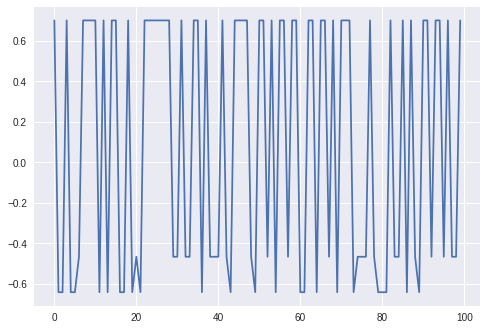

In [ ]:
plt.plot(biases)
plt.show()

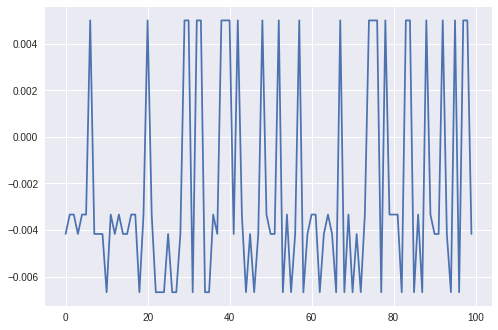

In [ ]:
plt.plot(drift_rates)
plt.show()

In [ ]:
output_mask_bias, output_mask_drift = np.zeros(data.shape[:2]), np.zeros(data.shape[:2])

In [ ]:
for row in range(data.shape[0]):
  for col in range(data.shape[1]):
    r_bias, p_bias = pearsonr(data[row, col, :], biases)
    r_drift, p_drift = pearsonr(data[row, col, :], drift_rates)
    output_mask_bias[row, col] = p_bias
    output_mask_drift[row, col] = p_drift

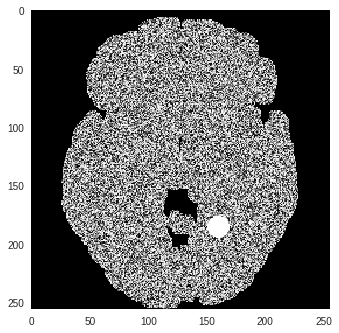

In [ ]:
plt.imshow(output_mask_bias)
plt.grid(False)
plt.show()

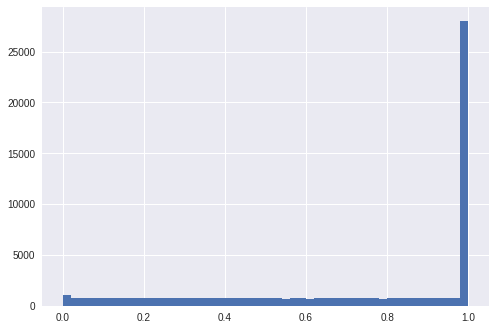

In [ ]:
plt.hist(output_mask_bias.flatten(), bins=50)
plt.show()

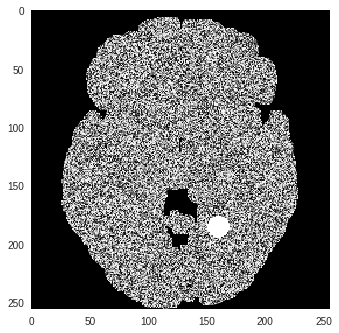

In [ ]:
plt.imshow(output_mask_drift)
plt.grid(False)
plt.show()

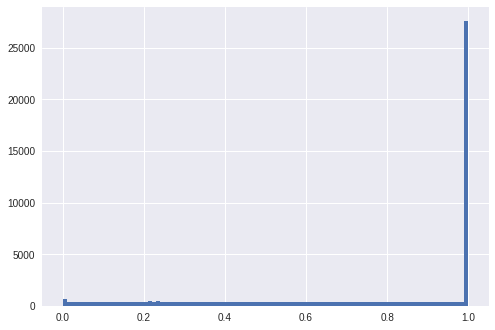

In [ ]:
plt.hist(output_mask_drift.flatten(), bins=100)
plt.show()